Loaded 12 songs.
Loading songs...
Loaded 12 songs.


c:\Users\srivi\anaconda3\envs\musify_env\Lib\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


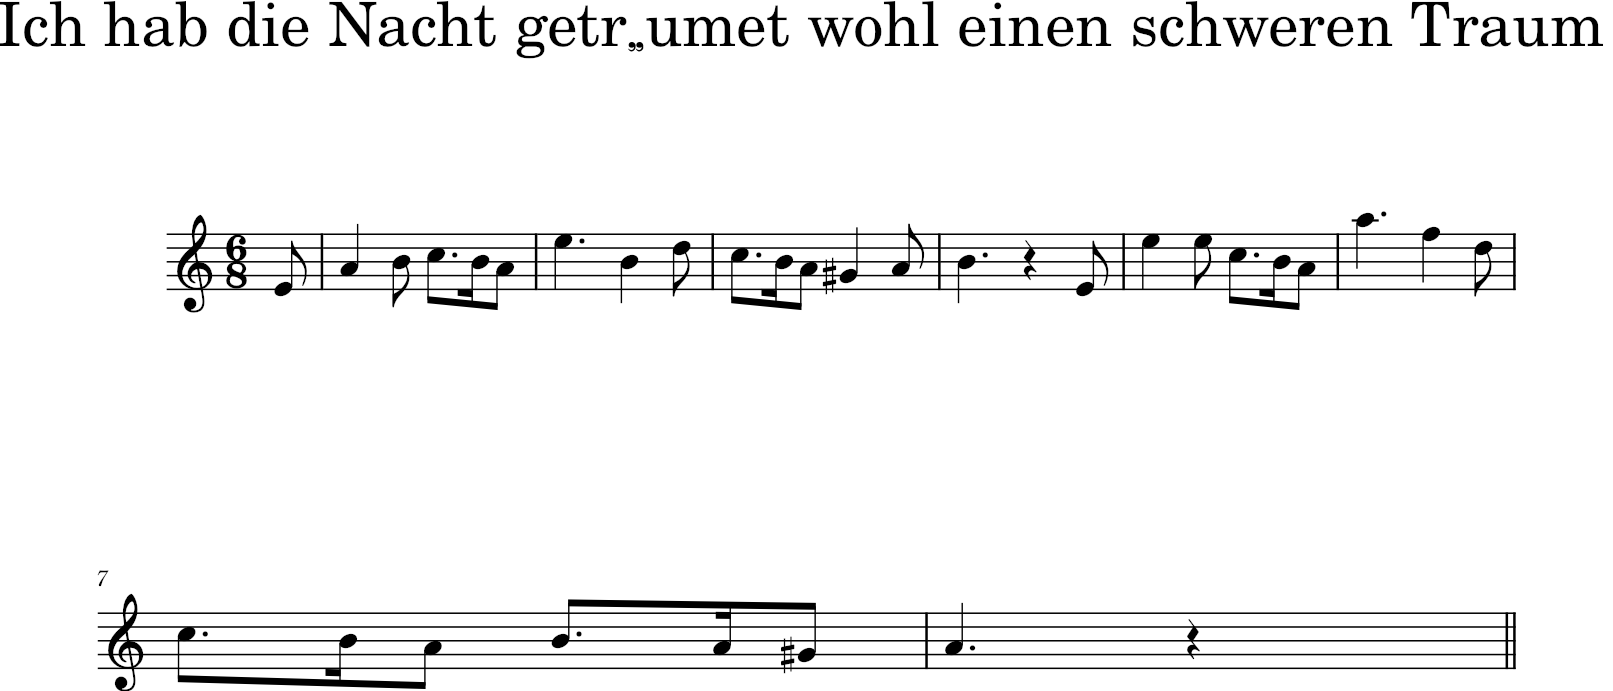

: 

In [ ]:
import os
import music21 as m21

KERN_DATASET_PATH = "deutschl/test"
SAVE_DIR = "dataset"

# durations are expressed in quarter length
ACCEPTABLE_DURATIONS = [
    0.25, # 16th note
    0.5, # 8th note
    0.75,
    1.0, # quarter note
    1.5,
    2, # half note
    3,
    4 # whole note
]


def load_songs_in_kern(dataset_path):
    """Loads all kern pieces in dataset using music21.

    :param dataset_path (str): Path to dataset
    :return songs (list of m21 streams): List containing all pieces
    """
    songs = []

    # go through all the files in dataset and load them with music21
    for path, subdirs, files in os.walk(dataset_path):
        for file in files:

            # consider only kern files
            if file[-3:] == "krn":
                song = m21.converter.parse(os.path.join(path, file))
                songs.append(song)
    return songs


def has_acceptable_durations(song, acceptable_durations):
    """Boolean routine that returns True if piece has all acceptable duration, False otherwise.

    :param song (m21 stream):
    :param acceptable_durations (list): List of acceptable duration in quarter length
    :return (bool):
    """
    for note in song.flat.notesAndRests:
        if note.duration.quarterLength not in acceptable_durations:
            return False
    return True


def transpose(song):
    """Transposes song to C maj/A min

    :param piece (m21 stream): Piece to transpose
    :return transposed_song (m21 stream):
    """

    # get key from the song
    parts = song.getElementsByClass(m21.stream.Part)
    measures_part0 = parts[0].getElementsByClass(m21.stream.Measure)
    key = measures_part0[0][4]

    # estimate key using music21
    if not isinstance(key, m21.key.Key):
        key = song.analyze("key")

    # get interval for transposition. E.g., Bmaj -> Cmaj
    if key.mode == "major":
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch("C"))
    elif key.mode == "minor":
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch("A"))

    # transpose song by calculated interval
    tranposed_song = song.transpose(interval)
    return tranposed_song


def encode_song(song, time_step=0.25):
    """Converts a score into a time-series-like music representation. Each item in the encoded list represents 'min_duration'
    quarter lengths. The symbols used at each step are: integers for MIDI notes, 'r' for representing a rest, and '_'
    for representing notes/rests that are carried over into a new time step. Here's a sample encoding:

        ["r", "_", "60", "_", "_", "_", "72" "_"]

    :param song (m21 stream): Piece to encode
    :param time_step (float): Duration of each time step in quarter length
    :return:
    """

    encoded_song = []

    for event in song.flat.notesAndRests:

        # handle notes
        if isinstance(event, m21.note.Note):
            symbol = event.pitch.midi # 60
        # handle rests
        elif isinstance(event, m21.note.Rest):
            symbol = "r"

        # convert the note/rest into time series notation
        steps = int(event.duration.quarterLength / time_step)
        for step in range(steps):

            # if it's the first time we see a note/rest, let's encode it. Otherwise, it means we're carrying the same
            # symbol in a new time step
            if step == 0:
                encoded_song.append(symbol)
            else:
                encoded_song.append("_")

    # cast encoded song to str
    encoded_song = " ".join(map(str, encoded_song))

    return encoded_song


def preprocess(dataset_path):

    # load folk songs
    print("Loading songs...")
    songs = load_songs_in_kern(dataset_path)
    print(f"Loaded {len(songs)} songs.")

    for i, song in enumerate(songs):

        # filter out songs that have non-acceptable durations
        if not has_acceptable_durations(song, ACCEPTABLE_DURATIONS):
            continue

        # transpose songs to Cmaj/Amin
        song = transpose(song)

        # encode songs with music time series representation
        encoded_song = encode_song(song)

        # save songs to text file
        save_path = os.path.join(SAVE_DIR, str(i))
        with open(save_path, "w") as fp:
            fp.write(encoded_song)


if __name__ == "__main__":

    # load songs
    songs = load_songs_in_kern(KERN_DATASET_PATH)
    print(f"Loaded {len(songs)} songs.")
    song = songs[0]

    preprocess(KERN_DATASET_PATH)

    # transpose song
    transposed_song = transpose(song)
    transposed_song.show()